# 1. Online Learning

##1.1. Online
- Stream-Data: Streaming data, data streams, 소스로 부터 빠르게 생성되는 데이터
 - Model Drift: Model drift or model decay, 모형 예측력의 저하
 - Windowing: window는 일정 시간에 대한 데이터 스냅샷. 스트림 데이터에 활용.
 - Incremental and Online Learning:
 - Incremental Learning: 새로운 배치의 데이터가 오는 경우, 모형 업데이트.
 - Online Learning: 새로운 관측이 발생될 때 마다 모형 업데이트. 미니배치까지 업데이트를 기다리지 않음.

### Model Drift의 두 가지 유형
- Concept Drift: 타겟변수 속성이 시간에 따라 변화
- 예: 개인화된 추천시스템의 User의 속성이 변화(이사...)
- Types of Concept Drifts:
1. Sudden Drift: 급격한 외부 변화로 인한 저하
2. Incremental Drift: 장기간 변화 누적
3. Recurrent Drift: 성능 저하가 주기적으로 발생, 예를 들어 블랙프라이데이 등

- Data Drift: X변수 값의 통계적 속성의 변화 등
- 데이터에 대한 모니터링을 통한 모형 저하 대비
1. Incremental learning with retraining model as new data arrives
2. Training with weighted data
3. Periodic retraining and updating models

- Batch Learning VS Online Learning
 - Batch Learning
 1. Splitting the data into train and test sets
 2. Fitting a model to the train set
 3. Computing the performance of the model on the test set
 4. Pushing the model to production

 - 모형이 현재 데이터에도 잘 작동하는지에 대한 이슈: 주기적으로 모형에 대한 업데이트(기존+신규 데이터)

 - Online Learning
 1. 모형이 전체 데이터 대신 증분 데이터 스트림에 학습
 2. 매 시점 관측된 상대적으로 작은 양의 데이터를 학습
 3. Library: river

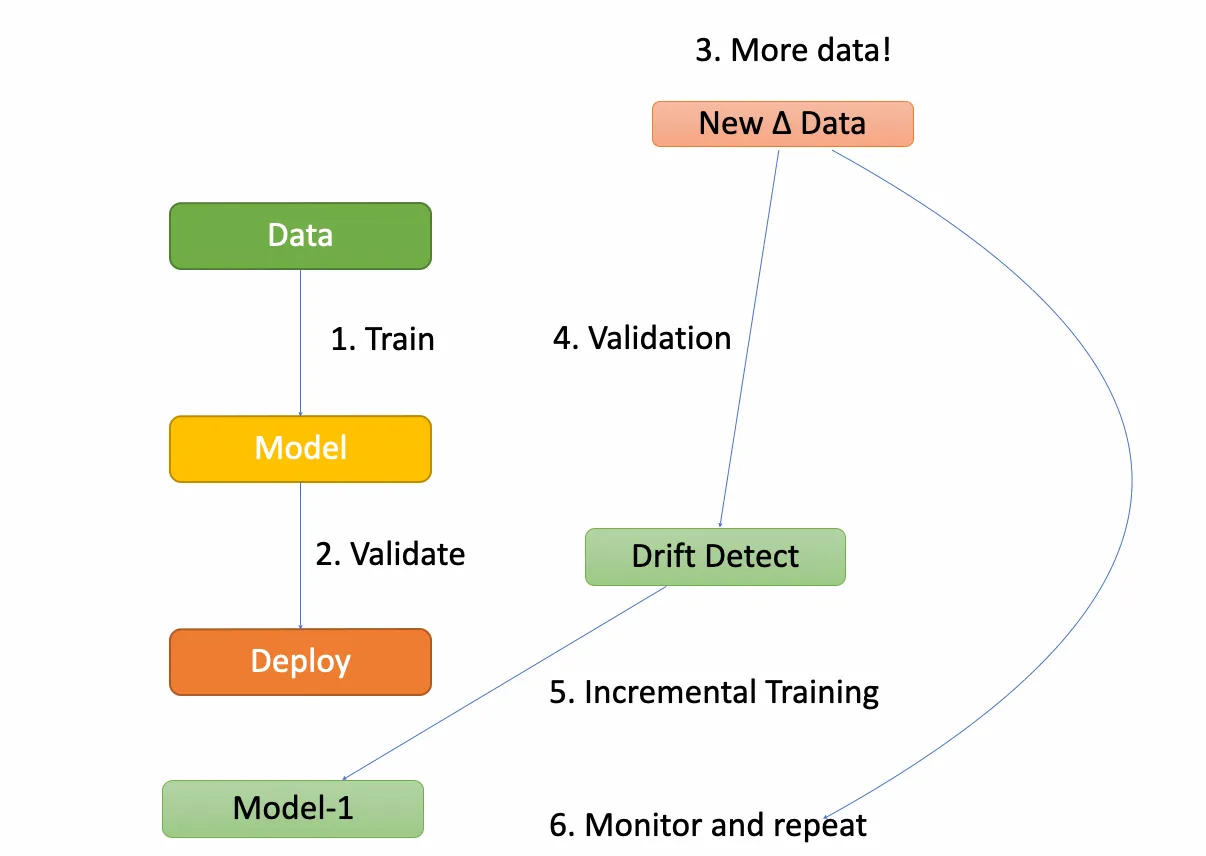

##1.2. river 라이브러리

- 지원 기능
- Linear models with a wide array of optimizers
- Nearest neighbors, decision trees, naïve Bayes
- Anomaly detection
- Drift detection
- Recommender systems
- Time series forecasting
- Imbalanced learning
- Clustering
- Feature extraction and selection
- Online statistics and metrics
- Built-in datasets
- Progressive model validation
- https://riverml.xyz/latest/api/overview/

In [ ]:
!pip install river

- Drift Detection using *ADWIN*

In [ ]:
import numpy as np
from river import drift

np.random.seed(42)

## Let us first create a 1000 datapoints with Standard Normal distribution (values will be between -1 to 1)

simulated_stream_data = np.random.randn(1000)
print(simulated_stream_data[:10])

# Data concept are changed from index 599 to 999 (we change the datapoints here)
for j in range(599, 1000):
    simulated_stream_data[j] = np.random.randint(5, high=9)


adwin = drift.ADWIN()

for i, val in enumerate(simulated_stream_data):
    adwin.update(val)  # 반환값 없음
    # 드리프트 감지 여부는 속성으로 확인
    if adwin.drift_detected:
        print(f"Change detected at index {i}, input value: {val}")
        adwin = drift.ADWIN()  # reset 대신 새로 생성

[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
Change detected at index 607, input value: 6.0


#2. Online 분류

- Bagging & Boosting

In [ ]:
from river import linear_model, metrics, preprocessing, stream

# 데이터 스트림 생성 (간단한 데이터)
dataset = stream.iter_array(
    X=[{'feature1': 1, 'feature2': 4},
       {'feature1': 2, 'feature2': 5},
       {'feature1': 3, 'feature2': 6}],
    y=[0, 1, 1]
)

# 모델 정의: 표준화 + 로지스틱 회귀
model = (
    preprocessing.OneHotEncoder() |
    preprocessing.StandardScaler() |
    linear_model.LogisticRegression()
)

# 실시간 평가 지표
accuracy = metrics.Accuracy()

for x, y in dataset:
    y_pred = model.predict_one(x)        # 예측
    model.learn_one(x, y)                # 학습
    accuracy.update(y, y_pred)           # 평가
    print(f"True: {y}, Pred: {y_pred}, Accuracy: {accuracy.get():.2f}")


True: 0, Pred: False, Accuracy: 1.00
True: 1, Pred: False, Accuracy: 0.50
True: 1, Pred: True, Accuracy: 0.67


- Online bagging

In [ ]:
from river import datasets
from river import ensemble
from river import evaluate
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing

dataset = datasets.Phishing()

# # run following to get details of dataset
# dataset
# # Taking a look at couple of the datapoints in dataset
# list(dataset.take(2))


## Build a simple logistic Regression for the task
log_model = (preprocessing.StandardScaler() |
             linear_model.LogisticRegression()
    )

## Build an Online Bagging Classifier
online_bagging = ensemble.BaggingClassifier(
    model=(
        preprocessing.StandardScaler() |
        linear_model.LogisticRegression()
    ),
    n_models=5,
)

metric = metrics.F1()

print("Logistic Regression model performance:",evaluate.progressive_val_score(dataset, log_model, metric))
print("Online Bagging model performance:",evaluate.progressive_val_score(dataset, online_bagging, metric))




Logistic Regression model performance: F1: 87.97%
Online Bagging model performance: F1: 87.94%


- Online boosting

In [ ]:
from river import datasets
from river import ensemble
from river import evaluate
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing

dataset = datasets.Phishing()

## Build a simple logistic Regression for the task
log_model = (preprocessing.StandardScaler() |
             linear_model.LogisticRegression()
    )

## Build an Online Bagging Classifier
online_boosting = ensemble.AdaBoostClassifier(
    model=(
        preprocessing.StandardScaler() |
        linear_model.LogisticRegression()
    ),
    n_models=5,
)

metric = metrics.F1()

print("Logistic Regression model performance:",evaluate.progressive_val_score(dataset, log_model, metric))
print("Online AdaBoostClassifier model performance:",evaluate.progressive_val_score(dataset, online_boosting, metric))



Logistic Regression model performance: F1: 87.97%
Online AdaBoostClassifier model performance: F1: 87.74%


#3. Online Learning VS Batch Learning Example

In [ ]:
import seaborn as sns

df = sns.load_dataset("penguins")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [ ]:
target = 'species'
y = df[target]
X = df.drop(target, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# Get numerical and categorical features
numeric_features = X_train.select_dtypes(exclude=object).columns
categorical_features = X_train.select_dtypes(include=object).columns

# Specify transformers for each type of features
numeric_transformer = SimpleImputer()
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder()
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Create a pipeline with transformers and classifier
sklearn_clf = make_pipeline(preprocessor, DecisionTreeClassifier())

In [ ]:
# Train the model
sklearn_clf.fit(X_train, y_train)

# Get prediction
y_pred = sklearn_clf.predict(X_test)

- Online Learning

In [ ]:
from river import (
    stream,
    compose,
    preprocessing,
    evaluate,
    metrics,
    tree,
    imblearn,
    stats,
)
import numbers

- stream 스타일로 데이터 제공

In [ ]:
for xi, yi in stream.iter_pandas(X, y):
    pass

In [ ]:
xi, yi

({'island': 'Biscoe',
  'bill_length_mm': 49.9,
  'bill_depth_mm': 16.1,
  'flipper_length_mm': 213.0,
  'body_mass_g': 5400.0,
  'sex': 'Male'},
 'Gentoo')

- Imputing: 기존의 Imputing을 사용하기 어려움
 - running statistics 활용
 - 예) running mean: update the mean whenever there is a new value. use that running mean to update the missing value.

- learn one method + transform one method

In [ ]:
X_sample = [{"age": 10}, {"age": 30}, {"age": None}, {"age": 2}]
mean = stats.Mean()
imputer = preprocessing.StatImputer(("age", mean))
for xi_sample in X_sample:
    imputer.learn_one(xi_sample)
    print(imputer.transform_one(xi_sample))

{'age': 10}
{'age': 30}
{'age': 20.0}
{'age': 2}


- pipeline

In [ ]:
cat = (
    compose.SelectType(object)
    | preprocessing.StatImputer()
    | preprocessing.OneHotEncoder(drop_zeros=True)
)
num = compose.SelectType(numbers.Number) | preprocessing.StatImputer()
preprocessor = num + cat

In [ ]:
preprocessor.learn_one(xi)
preprocessor.transform_one(xi)

{'island_Biscoe': 1,
 'bill_length_mm_49.9': 1,
 'bill_depth_mm_16.1': 1,
 'flipper_length_mm_213.0': 1,
 'body_mass_g_5400.0': 1,
 'sex_Male': 1,
 'bill_length_mm': 49.9,
 'bill_depth_mm': 16.1,
 'flipper_length_mm': 213.0,
 'body_mass_g': 5400.0}

- Hoeffding Tree (HT) classifier:  online learning 모형, incremental decision trees의 한 종류

In [ ]:
classifier = tree.HoeffdingTreeClassifier()

In [ ]:
def get_pipeline():
    cat = (
        compose.SelectType(object)
        | preprocessing.StatImputer()
        | preprocessing.OneHotEncoder(drop_zeros=True)
    )
    num = compose.SelectType(numbers.Number) | preprocessing.StatImputer()
    classifier = tree.HoeffdingTreeClassifier()

    return (num + cat) | classifier

pipeline = get_pipeline()

In [ ]:
pipeline

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        <class 'numbers.Number'>
      ),
      StatImputer (
        imputers=()
      )
    ),
    Pipeline (
      Select (
        <class 'object'>
      ),
      StatImputer (
        imputers=()
      ),
      OneHotEncoder (
        drop_zeros=True
        drop_first=False
      )
    )
  ),
  HoeffdingTreeClassifier (
    grace_period=200
    max_depth=980
    split_criterion="info_gain"
    delta=1e-07
    tau=0.05
    leaf_prediction="nba"
    nb_threshold=0
    nominal_attributes=None
    splitter=GaussianSplitter (
      n_splits=10
    )
    binary_split=False
    min_branch_fraction=0.01
    max_share_to_split=0.99
    max_size=100.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  )
)

- 각 스트림에 대해 다음을 반복
 - 기존 모형으로 예측 수행
 - 새로운 예측에 대한 F1과 Confusion matrix 계산 후 기존 score 수정
 - 모형 훈련 및 업데이트 반복

In [ ]:
def train(X, y):
    pipeline = get_pipeline()

    # Initialize metrics
    f1_score = metrics.MicroF1()
    cm = metrics.ConfusionMatrix()

    f1_scores = []

    # Iterate over the dataset
    for xi, yi in stream.iter_pandas(X, y, shuffle=True, seed=1):
        # Predict the new sample
        yi_pred = pipeline.predict_one(xi)

        # Get the score
        if yi_pred is not None:
            f1_score.update(yi, yi_pred)
            f1_scores.append(f1_score.get() * 100)
            cm.update(yi, yi_pred)

        # Train the model with the new sample
        pipeline.learn_one(xi, yi)

    return f1_scores, cm, pipeline


f1_scores, cm, pipeline = train(X, y)

In [ ]:
pipeline.steps['HoeffdingTreeClassifier'].summary

{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 344.0}

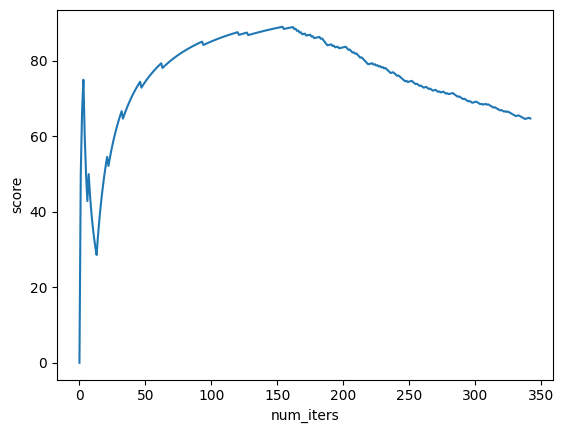

In [ ]:
import matplotlib.pyplot as plt

def plot(scores: list):
    iters = range(len(scores))
    ax = sns.lineplot(x=iters, y=scores)
    ax.set(xlabel='num_iters', ylabel='score')
    plt.show()

plot(f1_scores)

In [ ]:
metric = metrics.MicroF1()

evaluate.progressive_val_score(
    dataset=stream.iter_pandas(X, y, shuffle=True, seed=1),
    model=pipeline,
    metric=metric,
    print_every=50, # print every 50 iterations
)

[50] MicroF1: 48.00%
[100] MicroF1: 45.00%
[150] MicroF1: 42.67%
[200] MicroF1: 48.00%
[250] MicroF1: 46.40%
[300] MicroF1: 45.33%
[344] MicroF1: 44.19%


MicroF1: 44.19%

In [ ]:
cm

            Adelie   Chinstrap   Gentoo  
   Adelie      143           8        0  
Chinstrap       44          22        2  
   Gentoo       66           1       57  

In [ ]:
y.value_counts()

,count
species,
Adelie,152
Gentoo,124
Chinstrap,68


- imbalanced data

In [ ]:
classifier = tree.HoeffdingTreeClassifier()
sampler = imblearn.RandomSampler(
    classifier=classifier,
    desired_dist={"Adelie": 0.1, "Gentoo": 0.4, "Chinstrap": 0.5},
    seed=2,
)
#imb 비율을 위와 같이 제공

In [ ]:
def get_pipeline():
    # Specify the transfomers
    cat = (
        compose.SelectType(object)
        | preprocessing.StatImputer()
        | preprocessing.OneHotEncoder(drop_zeros=True)
    )
    num = compose.SelectType(numbers.Number) | preprocessing.StatImputer()

    # Specify classifiers
    classifier = tree.HoeffdingTreeClassifier()
    sampler = imblearn.RandomSampler(
        classifier=classifier,
        desired_dist={"Adelie": 0.1, "Gentoo": 0.4, "Chinstrap": 0.5},
        seed=2,
    )
    return (num + cat) | sampler

f1_scores, cm, pipeline = train(X, y)

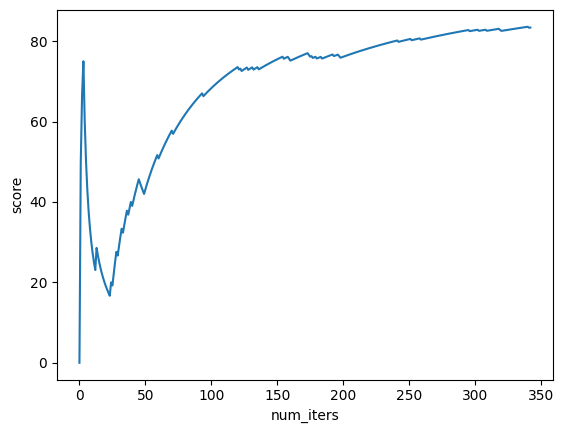

In [ ]:
plot(f1_scores)

In [ ]:
cm

            Adelie   Chinstrap   Gentoo  
   Adelie      111          37        3  
Chinstrap        5          62        1  
   Gentoo        5           6      113  

In [ ]:
pipeline = get_pipeline()

metric = metrics.MicroF1()

evaluate.progressive_val_score(
    dataset=stream.iter_pandas(X, y, shuffle=True, seed=1),
    model=pipeline,
    metric=metric,
    print_every=50,
)

[50] MicroF1: 42.86%
[100] MicroF1: 67.68%
[150] MicroF1: 75.17%
[200] MicroF1: 75.88%
[250] MicroF1: 80.32%
[300] MicroF1: 82.61%
[344] MicroF1: 83.38%


MicroF1: 83.38%

#4. Online Clustering

In [ ]:
from river import cluster
import numpy as np

# 샘플 데이터
X = [{'x': np.random.rand(), 'y': np.random.rand()} for _ in range(10)]

# KMeans 초기화
model = cluster.KMeans(n_clusters=2, seed=42)

# 데이터 스트림 처리
for i, x in enumerate(X, 1):
    cluster_id = model.predict_one(x)  # 클러스터 예측
    model.learn_one(x)                 # 모델 업데이트 (반환값 할당 X)
    print(f"{i}번째 데이터 {x} → 클러스터 {cluster_id}")

# 최종 클러스터 중심 출력
print("\n최종 클러스터 중심:")
for i, center in enumerate(model.centers, 1):
    print(f"클러스터 {i}: {center}")


1번째 데이터 {'x': 0.46349404380057235, 'y': 0.3797857801792298} → 클러스터 1
2번째 데이터 {'x': 0.8633336495718252, 'y': 0.519081785136218} → 클러스터 1
3번째 데이터 {'x': 0.47918187762973097, 'y': 0.025642065806435688} → 클러스터 1
4번째 데이터 {'x': 0.34124782762615635, 'y': 0.38019561878585706} → 클러스터 1
5번째 데이터 {'x': 0.3988227808969005, 'y': 0.5801723692273323} → 클러스터 1
6번째 데이터 {'x': 0.5336025467268785, 'y': 0.6079050927934446} → 클러스터 1
7번째 데이터 {'x': 0.7648832615421283, 'y': 0.8129857387160935} → 클러스터 1
8번째 데이터 {'x': 0.7181230762264944, 'y': 0.9555236959549347} → 클러스터 1
9번째 데이터 {'x': 0.01823258267636163, 'y': 0.1957779856835461} → 클러스터 0
10번째 데이터 {'x': 0.00756287497814212, 'y': 0.647474714154603} → 클러스터 0

최종 클러스터 중심:
클러스터 1: 0
클러스터 2: 1


#5. Online AR

In [ ]:
from river import utils
from collections import defaultdict

# 스트림 트랜잭션 데이터
transactions = [
    {"milk", "bread", "butter"},
    {"bread", "butter"},
    {"milk", "bread"},
    {"milk", "butter"},
    {"bread", "butter", "eggs"}
]

# 최소 지지도 및 신뢰도
min_support = 0.4
min_confidence = 0.6

# 아이템 카운트
item_counts = defaultdict(int)
pair_counts = defaultdict(int)
transaction_count = 0

for transaction in transactions:
    transaction_count += 1
    for item in transaction:
        item_counts[item] += 1
    for item_a in transaction:
        for item_b in transaction:
            if item_a != item_b:
                pair_counts[(item_a, item_b)] += 1

# 연관 규칙 출력
print("\n연관 규칙:")
for (a, b), count in pair_counts.items():
    support = count / transaction_count
    confidence = count / item_counts[a]
    if support >= min_support and confidence >= min_confidence:
        print(f"{a} → {b} (support={support:.2f}, confidence={confidence:.2f})")



연관 규칙:
butter → bread (support=0.60, confidence=0.75)
milk → butter (support=0.40, confidence=0.67)
milk → bread (support=0.40, confidence=0.67)
bread → butter (support=0.60, confidence=0.75)


#6. 온라인 추천

In [ ]:
from river import reco
from river import metrics

# 1. 데이터: (사용자, 아이템, 평점)
ratings = [
    ('user1', 'movie1', 4),
    ('user1', 'movie2', 5),
    ('user2', 'movie1', 3),
    ('user2', 'movie3', 2),
    ('user3', 'movie2', 4),
    ('user3', 'movie3', 5),
]

# 2. 협업필터링 모델 정의 (Bias + Matrix Factorization)
model = reco.BiasedMF(
    n_factors=10,      # 잠재 요인(latent factors) 개수
    seed=42
)

# 3. 평가 지표
rmse = metrics.RMSE()

# 4. 데이터 온라인 학습
for user, item, rating in ratings:
    y_pred = model.predict_one(user, item)  # 예측
    if y_pred is None:
        y_pred = 3.0  # 초기값(default rating)
    print(f"예측: {y_pred:.2f}, 실제: {rating}")

    model.learn_one(user, item, rating)     # 모델 업데이트
    rmse.update(rating, y_pred)

print(f"\n최종 RMSE: {rmse.get():.4f}")

# 5. 새 데이터에 대한 예측
new_user = 'user4'
new_item = 'movie1'
pred = model.predict_one(new_user, new_item)
print(f"\n'{new_user}'의 '{new_item}' 예상 평점: {pred:.2f}")


예측: -0.04, 실제: 4
예측: 3.97, 실제: 5
예측: 4.51, 실제: 3
예측: 3.95, 실제: 2
예측: 3.51, 실제: 4
예측: 3.54, 실제: 5

최종 RMSE: 2.0743

'user4'의 'movie1' 예상 평점: 3.83
